# Canonical correlation analysis in python

In this notebook, we will walk through the solution to the basic algrithm of canonical correlation analysis and compare that to the output of implementations in existing python libraries `statsmodels` and `scikit-learn`. 



In [2]:
import numpy as np
from scipy.linalg import sqrtm

from statsmodels.multivariate.cancorr import CanCorr as smCCA
from sklearn.cross_decomposition import CCA as skCCA

import matplotlib.pyplot as plt
from seaborn import heatmap

Let's define a plotting functon for the output first.

In [3]:
def plot_cca(a, b, U, V, s):
    # plotting
    plt.figure()
    heatmap(a, square=True, center=0)
    plt.title("Canonical vector - x")
    plt.figure()
    heatmap(b, square=True, center=0)
    plt.title("Canonical vector - y")

    plt.figure(figsize=(9, 6))
    for i in range(N):

        plt.subplot(221 + i)
        plt.scatter(np.array(X_score[:, i]).reshape(100), 
                    np.array(Y_score[:, i]).reshape(100), 
                    marker="o", c="b", s=25)
        plt.xlabel("Canonical variate of X")
        plt.ylabel("Canonical variate of Y")
        plt.title('Mode %i (corr = %.2f)' %(i + 1, s[i]))
        plt.xticks(())
        plt.yticks(())

## Create data based on some latent variables

First generate some test data.
The code below is modified based on the scikit learn example of CCA. 
The aim of using simulated data is that we can have complete control over the structure of the data and help us see the utility of CCA.

Let's create a dataset with 100 observations with two hidden variables:

In [4]:
n = 100
# fix the random seed so this tutorial will always create the same results
np.random.seed(42)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

For each observation, there are two domains of data. 
Six and four variables are measured in each of the domain. 
In domain 1 (x), the first latent structure 1 is underneath the first 3 variables and latent strucutre 2 for the rest.
In domain 2 (y), the first latent structure 1 is underneath every other variable and for latent strucutre 2 as well.

In [5]:
latents_x = np.array([l1, l1, l1, l2, l2, l2]).T
latents_y = np.array([l1, l2, l1, l2]).T

Now let's add some random noise on this latent structure.

In [7]:
X = latents_x + np.random.normal(size=6 * n).reshape((n, 6))
Y = latents_y + np.random.normal(size=4 * n).reshape((n, 4))

The aim of CCA is finding the correlated latent features in the two domains of data.  
Therefore, we would expect to find the hidden strucure is laid out in the latent components. 

## SVD algebra solution
SVD solution is the most implemented way of CCA solution. For the proof of standard eigenvalue solution and the proof SVD solution demonstrated below, see [Uurtio wt. al, (2018)](https://dl.acm.org/citation.cfm?id=3136624). 

The first step is getting the covariance matrixes of X and Y.

In [6]:
Cx, Cy = np.corrcoef(X.T), np.corrcoef(Y.T)
Cxy =  np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:]
Cyx =  Cxy.T

We first retrieve the identity form of the covariance matix of X and Y.

In [7]:
sqrt_x, sqrt_y = np.matrix(sqrtm(Cx)), np.matrix(sqrtm(Cy))
isqrt_x, isqrt_y = sqrt_x.I, sqrt_y.I

According to the proof, we leared that the canonical correlation can be retrieved from SVD on Cx^-1/2 Cxy Cy^-1/2.

In [8]:
W = isqrt_x * Cxy * isqrt_y
u, s, v = np.linalg.svd(W)

The columns of the matrices U and V correspond to the sets of orthonormal left and right singular vectors respectively. The singular values of matrix S correspond to
the canonical correlations. The positions w a and w b are obtained from:

In [9]:
N = np.min([X.shape[1], Y.shape[1]])
a = np.dot(u, isqrt_x.T[:, :N]) / np.std(X) # scaling because we didn't standardise the input
b = np.dot(v, isqrt_y).T / np.std(Y)

Now compute the score.

In [10]:
X_score, Y_score = X.dot(a), Y.dot(b)

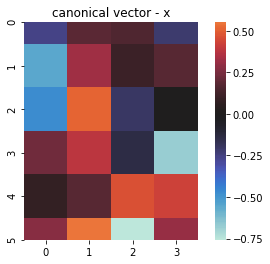

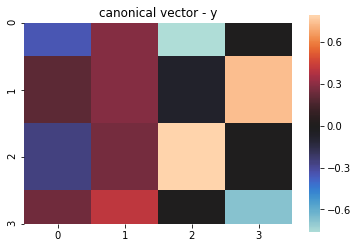

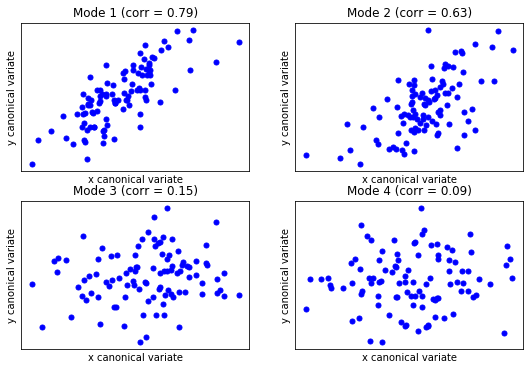

In [11]:
plot_cca(a, b, X_score, Y_score, s)  # predefined plotting function

## Solution Using SVD Only

The solution above can be further simplified by conducting SVD on the two domains. 
The algorithm SVD X and Y. This step is similar to doing principle component analysis on the two domains. 

In [12]:
ux, sx, vx = np.linalg.svd(X, 0)
uy, sy, vy = np.linalg.svd(Y, 0)

Then take the unitary bases and form UxUy^T and SVD it. S would be the canonical correlation of the two domanins of features. 

In [13]:
u, s, v = np.linalg.svd(ux.T.dot(uy), 0)

We can yield the canonical vectors by transforming the unitary basis in the hidden space back to the original space.

In [14]:
a = (vx.T).dot(u)  # no scaling here as SVD handled it.
b = (vy.T).dot(v.T)

X_score, Y_score = X.dot(a), Y.dot(b)

Now we can plot the results. It shows very similar results to solution 1.

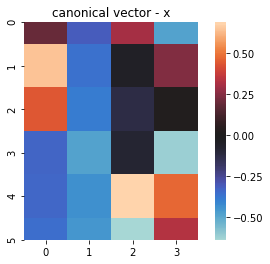

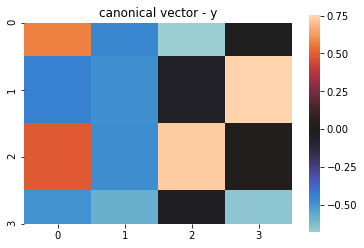

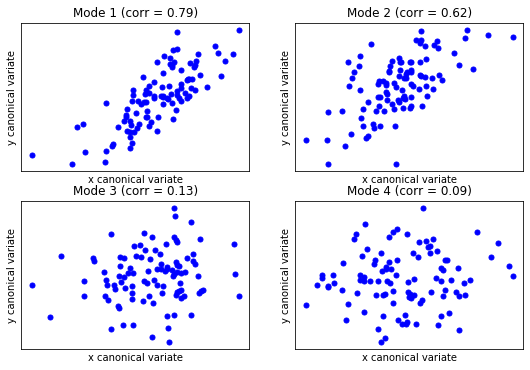

In [15]:
plot_cca(a, b, X_score, Y_score, s)  # predefined plotting function

The method above has been implemented in `Statsmodels`. The results are almost identical:

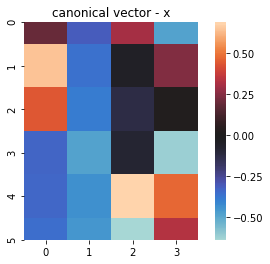

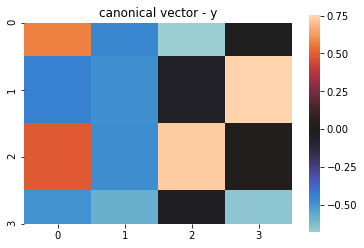

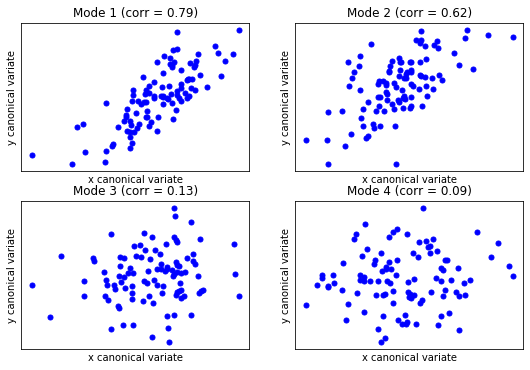

In [16]:
sm_cca = smCCA(Y, X)
sm_s = sm_cca.cancorr
sm_a = sm_cca.x_cancoef
sm_b = sm_cca.y_cancoef
sm_X_score = X.dot(a)
sm_Y_score = Y.dot(b)

plot_cca(a, b, X_score, Y_score, s)

## Scikit learn

Scikit learn implemented [a different algorithm](https://www.stat.washington.edu/sites/default/files/files/reports/2000/tr371.pdf). 
The outcome of the Scikit learn implementation yield very similar results.
The first mode capture the hidden structure in the simulated data. 

In [17]:
cca = skCCA(n_components=4)
cca.fit(X, Y)

CCA(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)

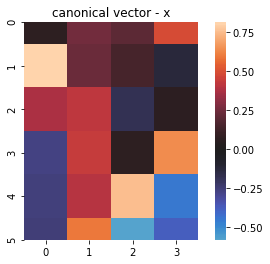

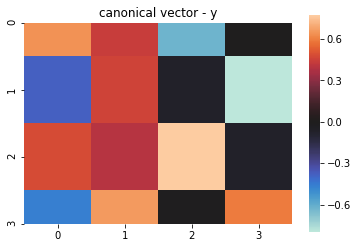

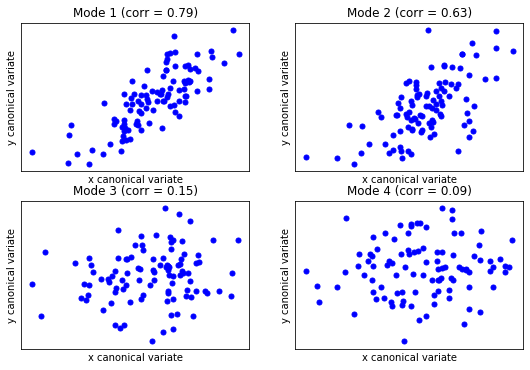

In [18]:
s = np.corrcoef(cca.x_scores_.T, cca.y_scores_.T).diagonal(offset=cca.n_components)
a = cca.x_weights_
b = cca.y_weights_

X_score, Y_score = cca.x_scores_, cca.y_scores_

plot_cca(a, b, X_score, Y_score, s)  # predefined plotting function